# Betting Framework

In this notebook, I am evaluating the score prediction models versus the betting odds of bookmakers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

## Kelly Criterion

I identify the best betting opportunity (the one with the highest expected value) and then place a bet using risk management: using the Kelly criterion, I am riding the maximum growth curve.

Here I use *Bet365* as the benchmark bookmaker.

In [3]:
bookmaker = 'B365'
odds_market = (
    pd.read_csv('../../data/betting/2021-22.csv')
    .loc[:, [
        "HomeTeam", "AwayTeam", "FTHG", "FTAG",
        f"{bookmaker}H", f"{bookmaker}D", f"{bookmaker}A"]]
    .rename(columns={
        "HomeTeam": "team1",
        "AwayTeam": "team2",
        "FTHG": "score1",
        "FTAG": "score2",
        f"{bookmaker}H": "home_win",
        f"{bookmaker}D": "draw",
        f"{bookmaker}A": "away_win"})
)

odds_market = odds_market.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man United': 'Manchester United',
    'Norwich': 'Norwich City',
    'Tottenham': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [4]:
# Get the model predictions.
outcome = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcome = (
    outcome
        .loc[
            (outcome['league_id'] == 2411) |
            (outcome['league_id'] == 2412)]
        .dropna()
    )

predictions_dixon_coles = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv"),
        outcome.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_spi = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
predictions_spi = (
    predictions_spi
    .loc[predictions_spi['league_id'] == 2411]
    .rename(columns={
        "prob1": "home_win_p",
        "probtie": "draw_p",
        "prob2": "away_win_p"})
    .loc[:, [
        'team1', 'team2', 'home_win_p', 'draw_p',
        'away_win_p', 'score1', 'score2']]
    .loc[predictions_spi['season'] == 2021]
    .loc[predictions_spi['score1'].notna()]
    )

In [5]:
df_dc = (
    pd.merge(
        predictions_dixon_coles.loc[:, [
            'team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        odds_market,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2'])
    .dropna()
    )

df_spi = (
    pd.merge(
        predictions_spi.loc[:, [
            'team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        odds_market,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2'])
    .dropna()
    )

In [6]:
def excepted_value(p_win, gain):
    return p_win * gain - (1 - p_win) * 0

df_dc['ev_h'] = df_dc.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
df_dc['ev_d'] = df_dc.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
df_dc['ev_a'] = df_dc.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

df_spi['ev_h'] = df_spi.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
df_spi['ev_d'] = df_spi.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
df_spi['ev_a'] = df_spi.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

In [7]:
def kelly_criterion(p, q):
    return p + (p - 1) / (q - 1)

df_dc['k_h'] = df_dc.apply(
    lambda row: kelly_criterion(row['home_win_p'], row['home_win']), axis=1)
df_dc['k_d'] = df_dc.apply(
    lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1)
df_dc['k_a'] = df_dc.apply(
    lambda row: kelly_criterion(row['away_win_p'], row['away_win']), axis=1)

df_spi['k_h'] = df_spi.apply(
    lambda row: kelly_criterion(row['home_win_p'], row['home_win']), axis=1)
df_spi['k_d'] = df_spi.apply(
    lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1)
df_spi['k_a'] = df_spi.apply(
    lambda row: kelly_criterion(row['away_win_p'], row['away_win']), axis=1)

In [8]:
from ranked_probability_score import match_outcome

df_dc['winner'] = match_outcome(df_dc)
df_spi['winner'] = match_outcome(df_spi)

In [9]:
def bet(row):
    global account_balance

    # Get highest potential event
    evs = np.array([row['ev_h'], row['ev_d'], row['ev_a']])
    edge = np.argmax(evs)

    start = account_balance
    # Ensure its profitable
    if evs[edge] > 1:
        
        # Get bet amount
        k = np.array([row['k_h'], row['k_d'], row['k_a']])[edge]
        # Ensure we bet a positive amount
        if k > 0:
            bet_value = k * account_balance
            account_balance -= bet_value

            # Get result of the bet
            if edge == row['winner'] == 0:
                account_balance += bet_value * row['home_win']

            elif edge == row['winner'] == 1:
                account_balance += bet_value * row['draw']

            elif edge == row['winner'] == 2:
                account_balance += bet_value * row['away_win']

    return (
        account_balance,
        edge if evs[edge] > 1 else -1,
        0 if account_balance > start else 1 if account_balance == start else 2
        )

account_balance = 100
(
    df_dc['balance'], 
    df_dc['bet_placed'],
    df_dc['bet_outcome']
    ) = zip(*df_dc.apply(bet, axis=1))
account_balance = 100
(
    df_spi['balance'],
    df_spi['bet_placed'],
    df_spi['bet_outcome']) = zip(*df_spi.apply(bet, axis=1))

Well, it turns out that my model is not yet ready to beat the odds. 🤣

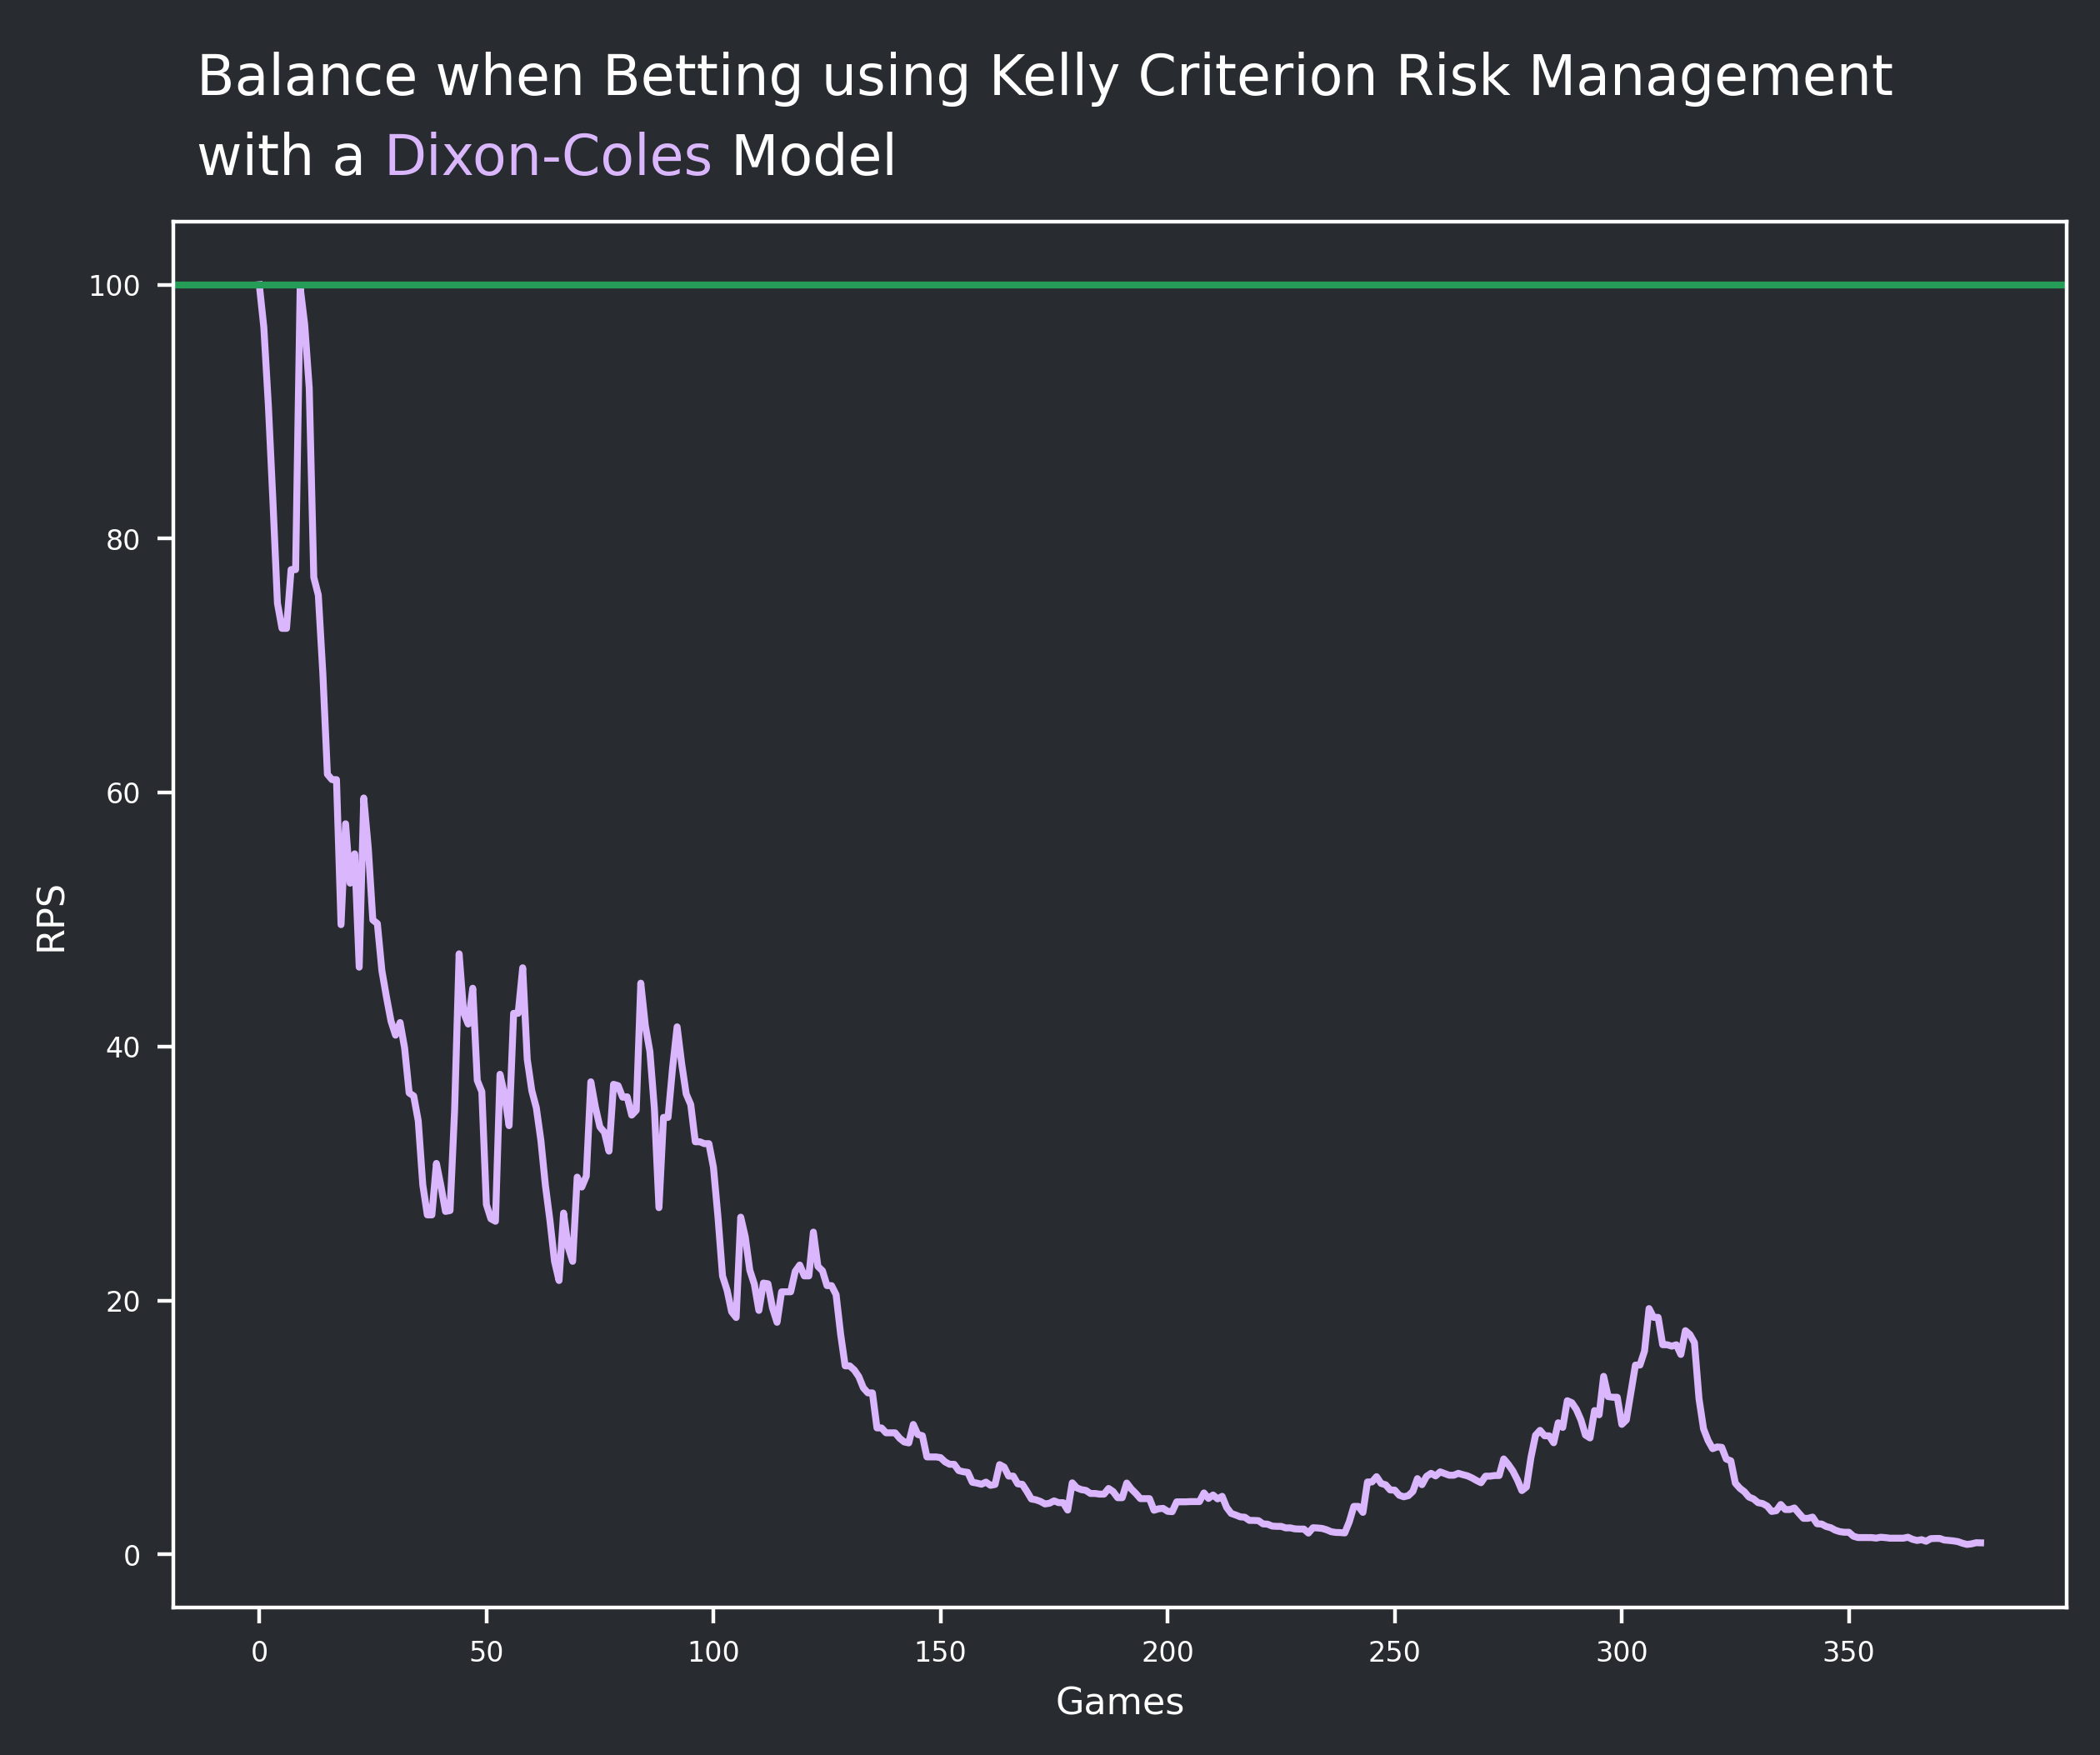

In [10]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(df_dc.balance.shift(1).fillna(100), color='#dab6fc')
# ax.plot(df_spi['balance'], color='#815ac0')

plt.axhline(y = 100, color = '#259C58', linestyle = '-')

ax.set_xlabel('Games', fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

fig_text(
    x=0.1, y=1.075,
    s="Balance when Betting using Kelly Criterion Risk Management",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.1, y=1.025,
    s="with a <Dixon-Coles> Model",
    # s="<Dixon-Coles> & <SPI> Model",
    highlight_textprops=[
            {"color": '#dab6fc'},
            # {"color": '#815ac0'}
        ],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
# fig_text(
#     x=0.82, y=1.,
#     s="Updated <15-03-2022>",
#     highlight_textprops=[{"fontweight": "bold"}],
#     fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [11]:
np.sum(df_dc.bet_placed == 0), np.sum(df_dc.bet_placed == 1), np.sum(df_dc.bet_placed == 2)

(91, 13, 224)

In [12]:
np.sum(df_dc.bet_outcome == 0), np.sum(df_dc.bet_outcome == 1), np.sum(df_dc.bet_outcome == 2)

(90, 52, 238)

### Sample Betting Example

In [13]:
sample = df_dc.loc[(df_dc.team1 == 'Liverpool') & (df_dc.team2 == 'Wolverhampton')]

ev_h = sample.apply(
    lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
ev_d = sample.apply(
    lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
ev_a = sample.apply(
    lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

# Betting on a draw has the highest Expected Value
(ev_h, ev_d, ev_a)

(379    0.769981
 dtype: float64,
 379    1.758363
 dtype: float64,
 379    1.752104
 dtype: float64)

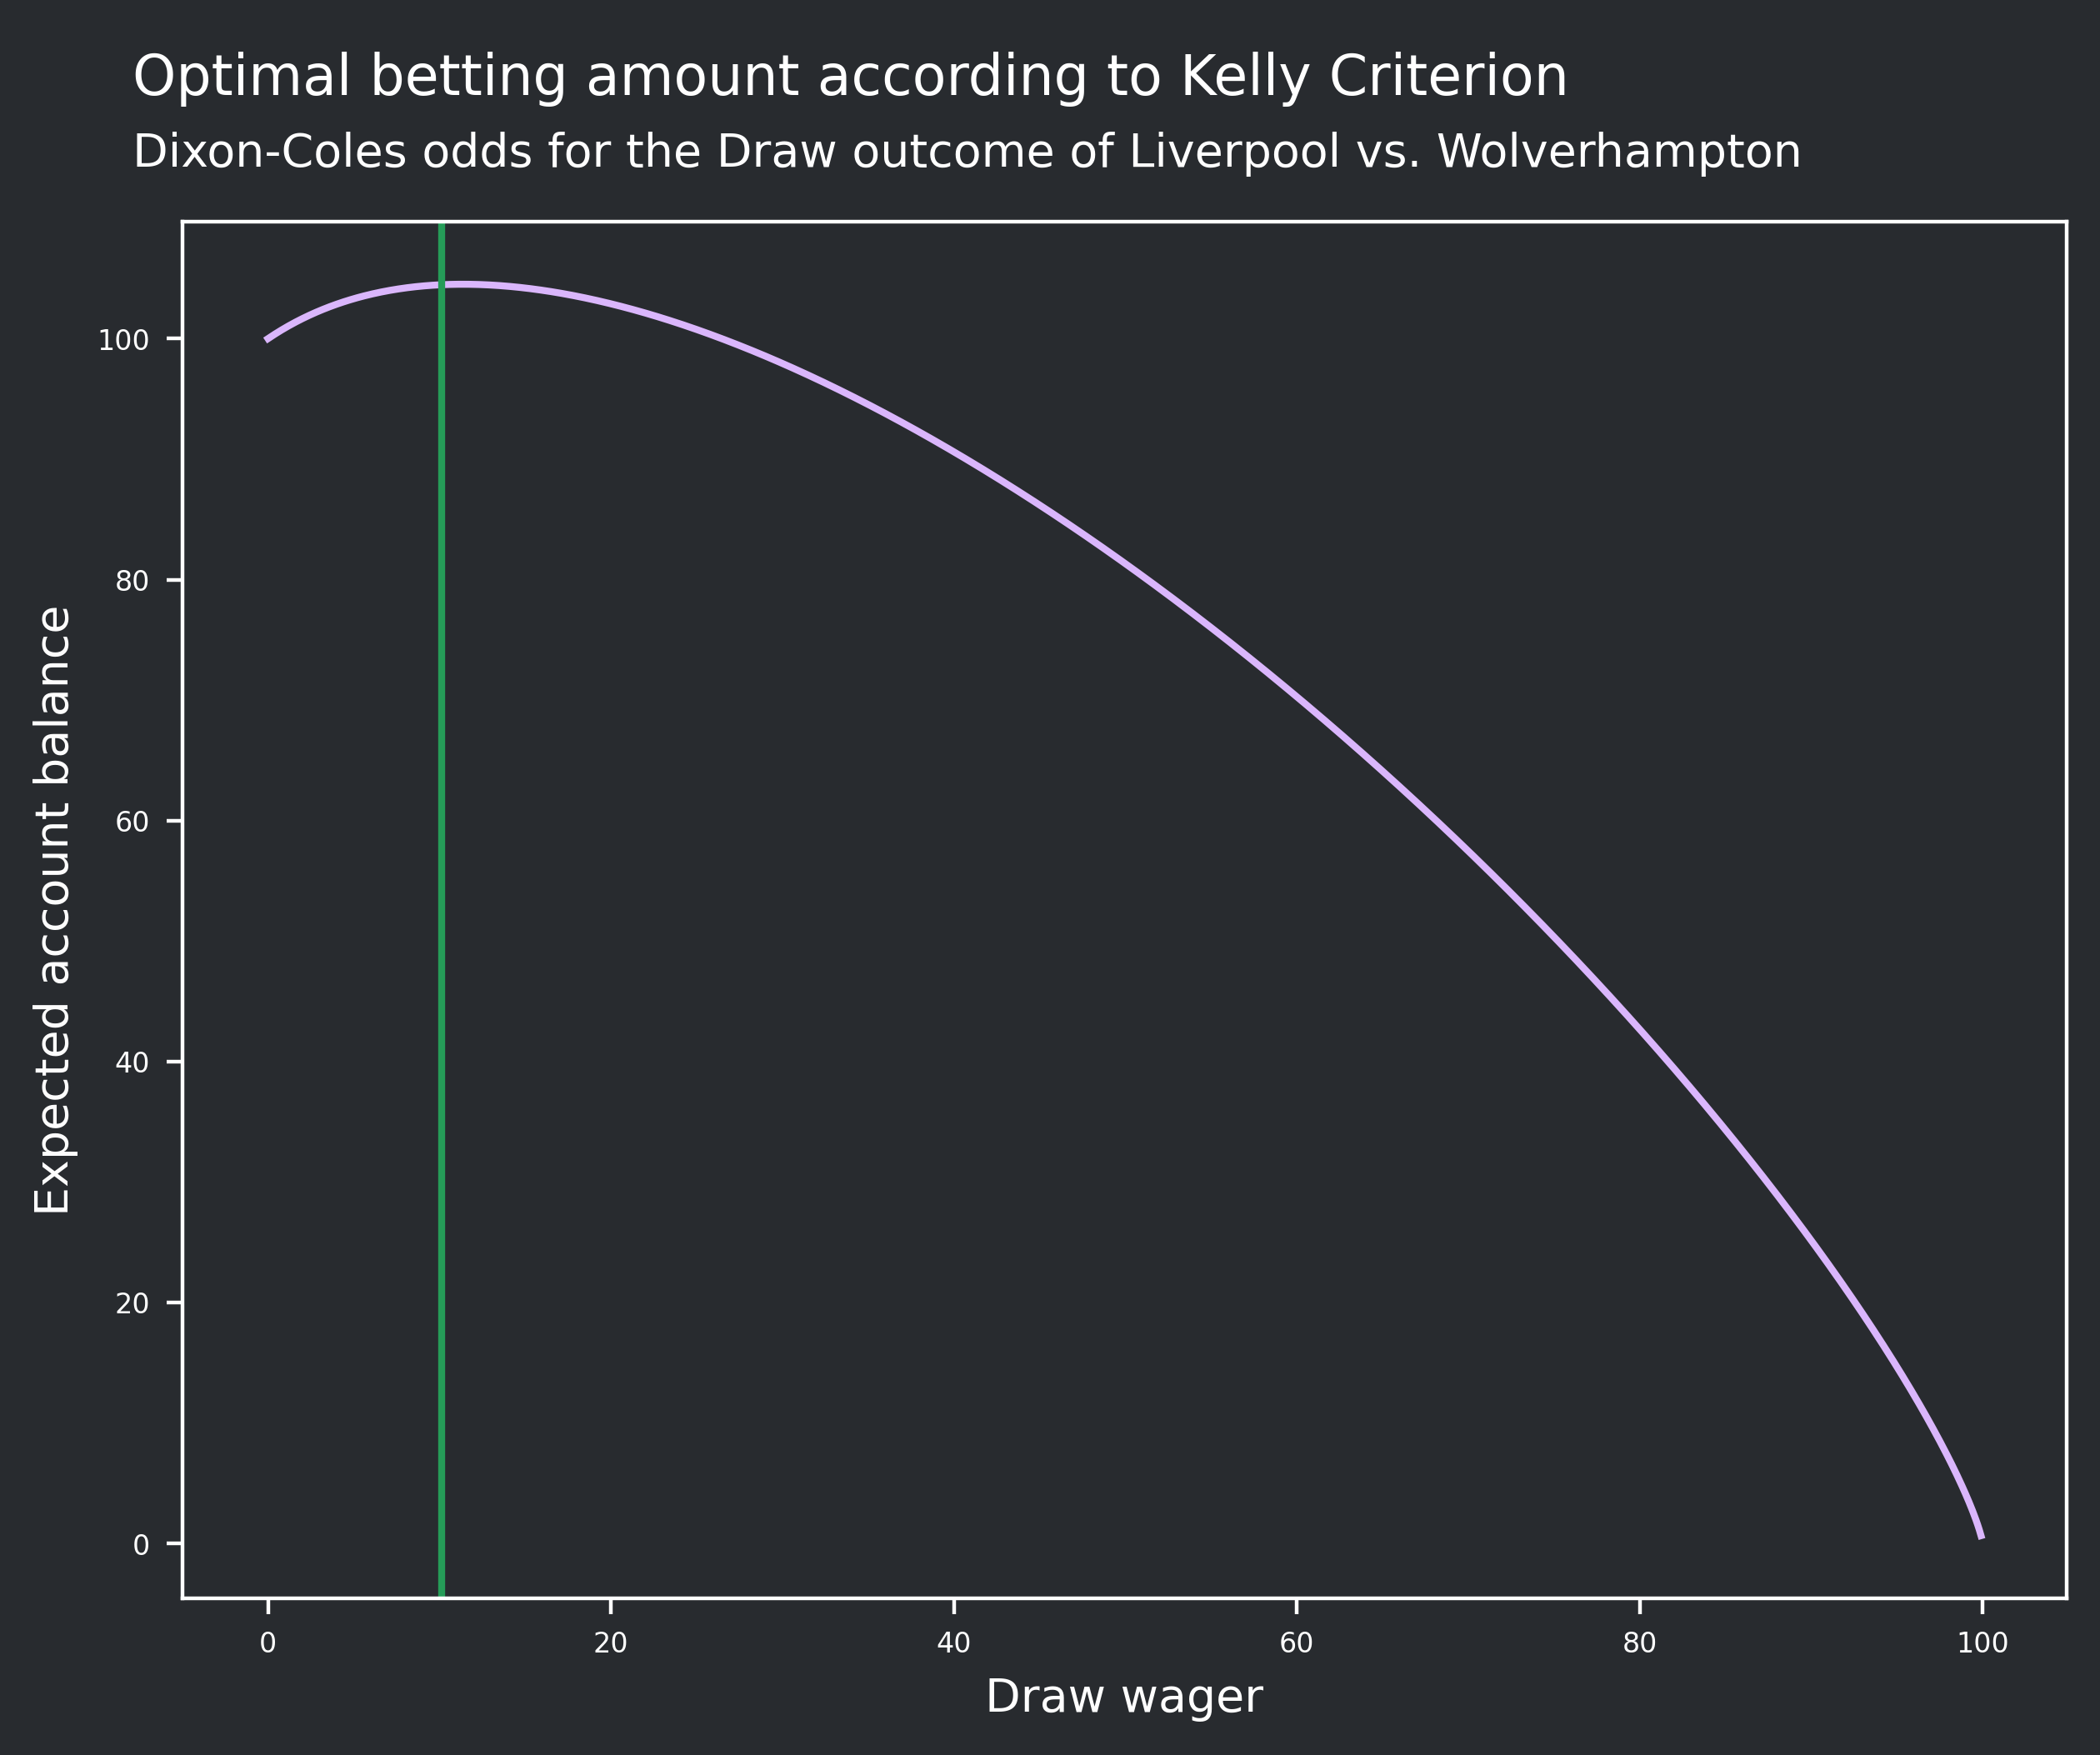

In [14]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    np.arange(0, 100, 0.1),
    (
        np.power(
            100 + np.arange(0, 100, 0.1) * sample.draw.values[0],
            sample.draw_p.values[0])
        ) *
    (
        np.power(
            100 - np.arange(0, 100, 0.1),
            1 - sample.draw_p.values[0])
        ),
    color = '#dab6fc',
    label='Growth curve')

plt.axvline(
    x = sample.apply(lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1).values[0] * 100,
    color = '#259C58', linestyle = '-', label='Maximum')

ax.set_xlabel('Draw wager')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Expected account balance')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.07, y=1.075,
    s="Optimal betting amount according to Kelly Criterion",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.07, y=1.025,
    s="Dixon-Coles odds for the Draw outcome of Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

## Kelly Criterion Optimization

Now, I will identify the best betting opportunity by maximizing the expected account balance (after placing bets and getting the payoff.

In [15]:
from scipy.optimize import minimize

def kco(parameters, odds, predictions, balance):
    ending_bankroll = np.zeros(3) + balance

    # parameters = np.where(parameters<0.1, 0, parameters)

    winnings = parameters * odds # Compute conditional winnings
    losses = np.sum(parameters) # Enter wager

    ending_bankroll += winnings
    ending_bankroll -= losses

    return - (
        np.log(ending_bankroll) * 
        predictions).sum()

def bet(row):
    global account_balance
    parameters = np.concatenate((
        np.zeros(3),  # Betting amount
    ))
    odds =  np.array([
        row.home_win,
        row.draw,
        row.away_win])
    predictions =  np.array([
        row.home_win_p,
        row.draw_p,
        row.away_win_p])

    # Force total betting amount to be below or equal to 100
    constraints = (
        {
            "type": "ineq",
            "fun": lambda x:
                - sum(x) + account_balance },
        )

    bounds = [(0, account_balance)] * 3
    start = account_balance

    solution = minimize(
        kco,
        parameters,
        args=(odds, predictions, account_balance),
        constraints=constraints,
        bounds=bounds,
        options={'disp': False, 'maxiter': 1000}
        )
    bet_amount = solution['x']

    # Remove all wagers from the account
    account_balance -= bet_amount[0] if bet_amount[0] >= 0.1 else 0
    account_balance -= bet_amount[1] if bet_amount[1] >= 0.1 else 0
    account_balance -= bet_amount[2] if bet_amount[2] >= 0.1 else 0

    # Get result of the bet
    if (bet_amount[0] >= 0.1) & (row['winner'] == 0):
        account_balance += bet_amount[0] * odds[0]

    if (bet_amount[1] >= 0.1) & (row['winner'] == 1):
        account_balance += bet_amount[1] * odds[1]

    if (bet_amount[2] >= 0.1) & (row['winner'] == 2):
        account_balance += bet_amount[2] * odds[2]

    return (
        account_balance,
        (bet_amount[0] if bet_amount[0] >= 0.1 else 0),
        (bet_amount[1] if bet_amount[1] >= 0.1 else 0),
        (bet_amount[2] if bet_amount[2] >= 0.1 else 0),
        0 if account_balance > start else 1 if account_balance == start else 2
        )

account_balance = 100
(
    df_dc['balance'],
    df_dc['wager_h'],
    df_dc['wager_d'],
    df_dc['wager_a'],
    df_dc['bet_outcome']
    ) = zip(*df_dc.apply(bet, axis=1))

account_balance = 100
(
    df_spi['balance'],
    df_spi['wager_h'],
    df_spi['wager_d'],
    df_spi['wager_a'],
    df_spi['bet_outcome']
    ) = zip(*df_spi.apply(bet, axis=1))

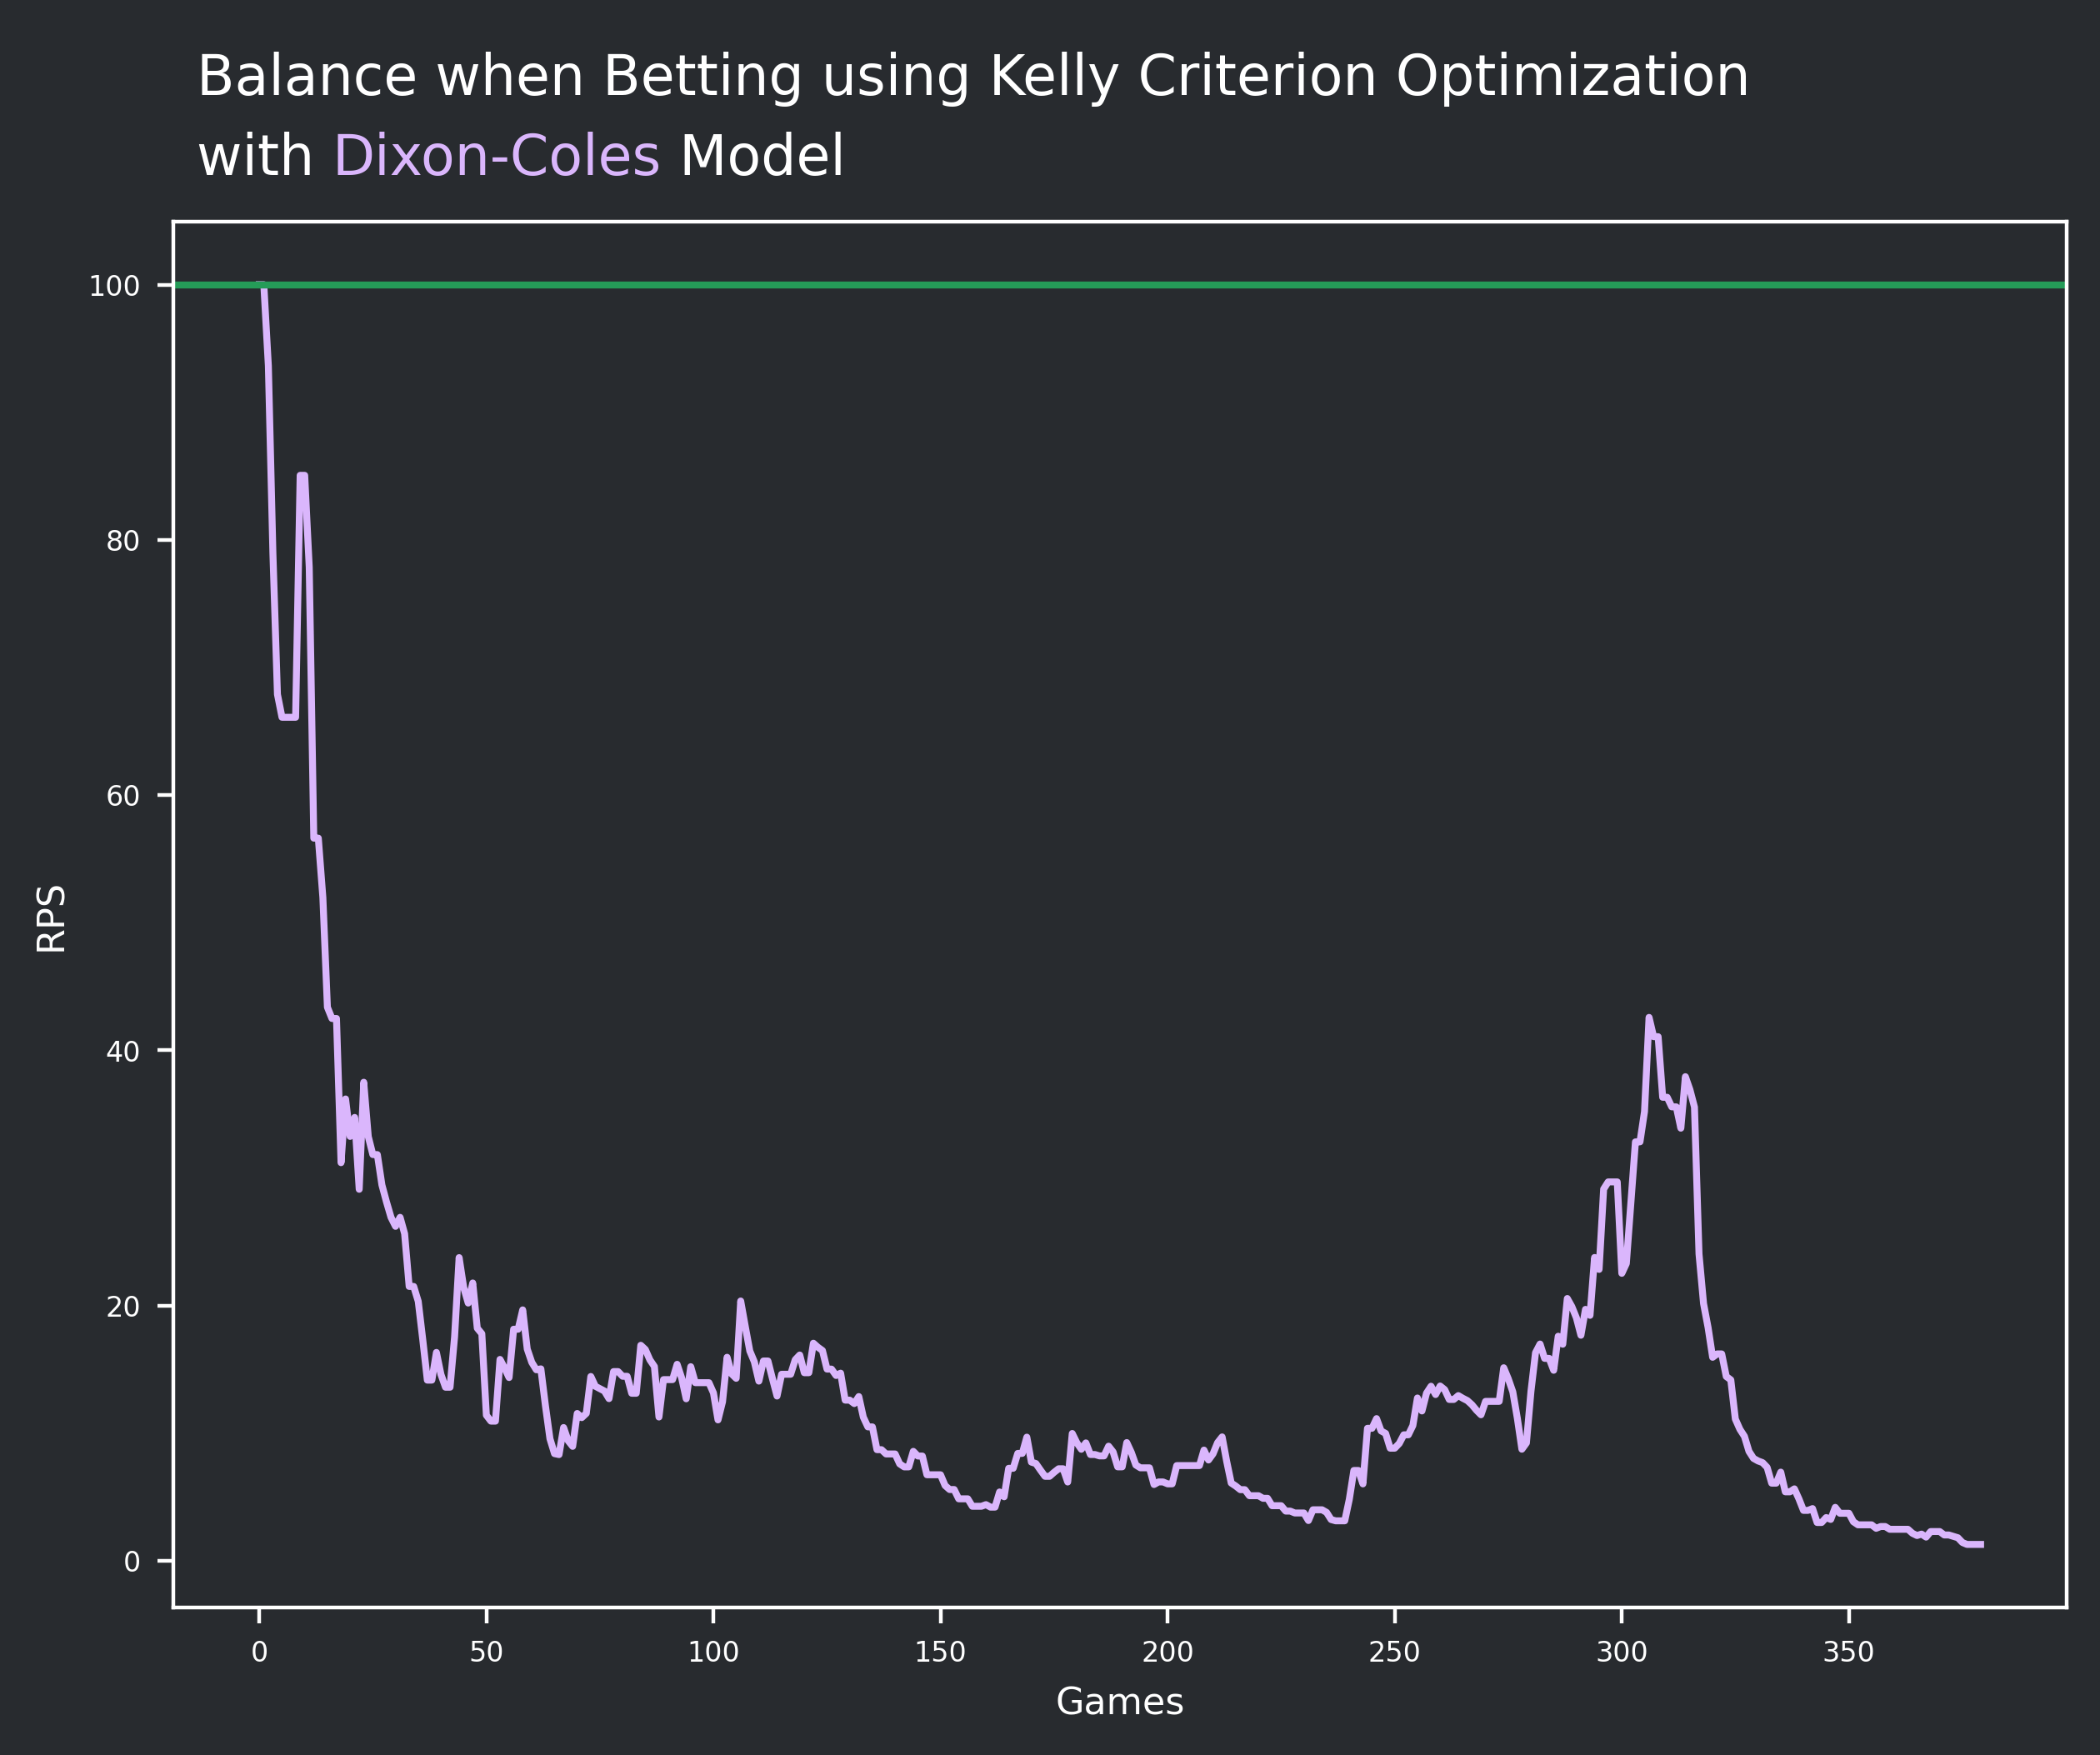

In [16]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(df_dc.balance.shift(1).fillna(100), color='#dab6fc')
# ax.plot(df_spi['balance'], color='#815ac0')

plt.axhline(y = 100, color = '#259C58', linestyle = '-')

ax.set_xlabel('Games', fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

fig_text(
    x=0.1, y=1.075,
    s="Balance when Betting using Kelly Criterion Optimization",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.1, y=1.025,
    s="with <Dixon-Coles> Model",
    highlight_textprops=[
            {"color": '#dab6fc'},
        ],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [17]:
np.sum(df_dc.bet_outcome == 0), np.sum(df_dc.bet_outcome == 1), np.sum(df_dc.bet_outcome == 2)

(90, 107, 183)

In [18]:
np.sum(df_dc.wager_h > 0), np.sum(df_dc.wager_d > 0), np.sum(df_dc.wager_a > 1)

(69, 126, 81)

In [19]:
(
    np.sum((df_dc.wager_h > 0) & (df_dc.wager_d > 0)) +
    np.sum((df_dc.wager_h > 0) & (df_dc.wager_a > 0)) +
    np.sum((df_dc.wager_d > 0) & (df_dc.wager_a > 0))
    )

119

### Sample Betting Example

In [20]:
sample = df_dc.loc[(df_dc.team1 == 'Liverpool') & (df_dc.team2 == 'Wolverhampton')]

account_balance = 100
sample.apply(bet, axis=1).values[0]

(82.88018035618194, 0, 10.963613215947635, 6.156206427870423, 2)

In [21]:
d = np.arange(0, 100)
a = np.arange(0, 100)

xgrid, ygrid = np.meshgrid(d, a)
xy = np.stack([xgrid, ygrid])

/tmp/ipykernel_4758/639771978.py:24: RuntimeWarning: divide by zero encountered in log
  predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +
/tmp/ipykernel_4758/639771978.py:24: RuntimeWarning: invalid value encountered in log
  predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +
/home/pf/.local/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:113: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


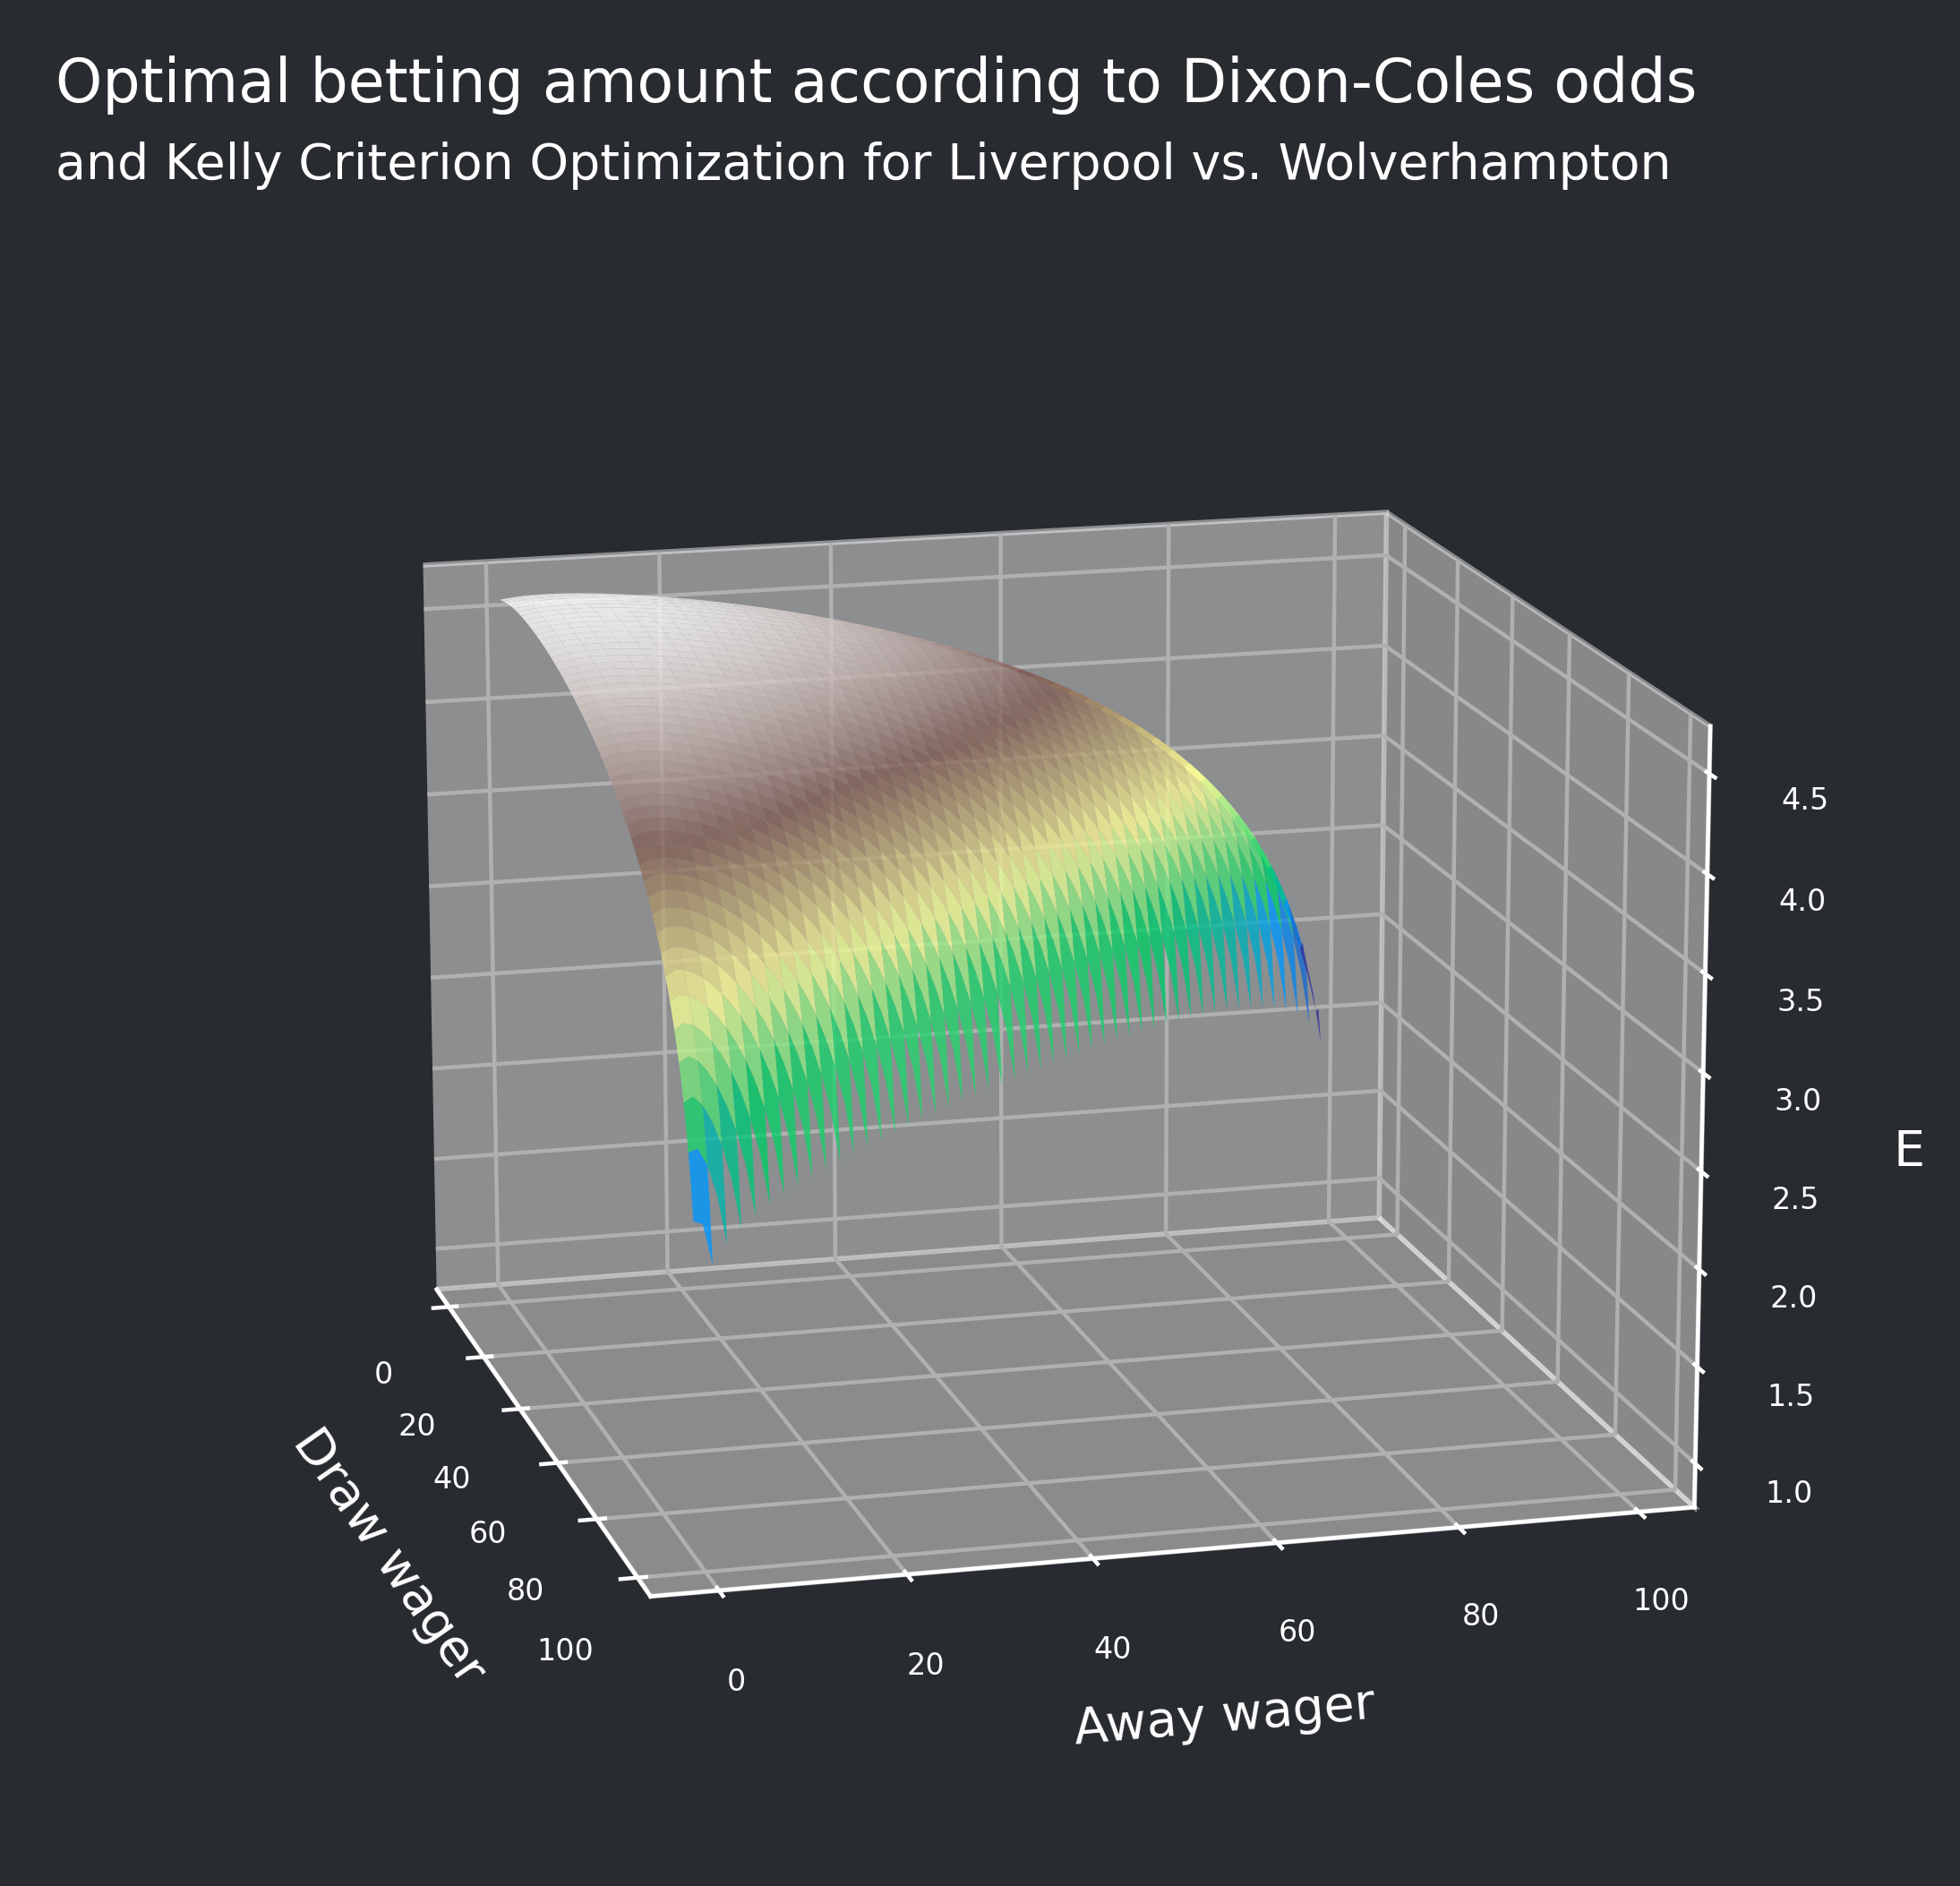

In [22]:
fig, ax = plt.subplots(tight_layout=True, subplot_kw=dict(projection='3d'))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.view_init(15, -15)

def kco(parameters, odds, predictions, balance):
    # Bank
    ending_bankroll_home = np.zeros((100, 100)) + balance
    ending_bankroll_draw = np.zeros((100, 100)) + balance
    ending_bankroll_away = np.zeros((100, 100)) + balance
    # Bets per outcome
    bets_home = np.zeros((100, 100))
    bets_draw = parameters[0]
    bets_away = parameters[1]
    # Conditional winning per outcome
    winning_home = bets_home * odds[0]
    winning_draw = bets_draw * odds[1]
    winning_away = bets_away * odds[2]
    # Losses
    losses = bets_home + bets_draw + bets_away

    E = (
        predictions[0] * np.log(ending_bankroll_home + winning_home - losses) +
        predictions[1] * np.log(ending_bankroll_draw + winning_draw - losses) +
        predictions[2] * np.log(ending_bankroll_away + winning_away - losses)
        )

    return E

E = kco(
    xy,
    sample[['home_win', 'draw', 'away_win']].values[0],
    sample[['home_win_p', 'draw_p', 'away_win_p']].values[0],
    100
    )

ax.plot_surface(
    xgrid,
    ygrid,
    E,
    cmap='terrain',
    alpha=.8
    )

ax.set_xlabel('Draw wager')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Away wager')
ax.yaxis.label.set_color('w')
ax.set_zlabel('E')
ax.zaxis.label.set_color('w')

fig_text(
    x=0.08, y=1.075,
    s="Optimal betting amount according to Dixon-Coles odds",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.08, y=1.025,
    s="and Kelly Criterion Optimization for Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

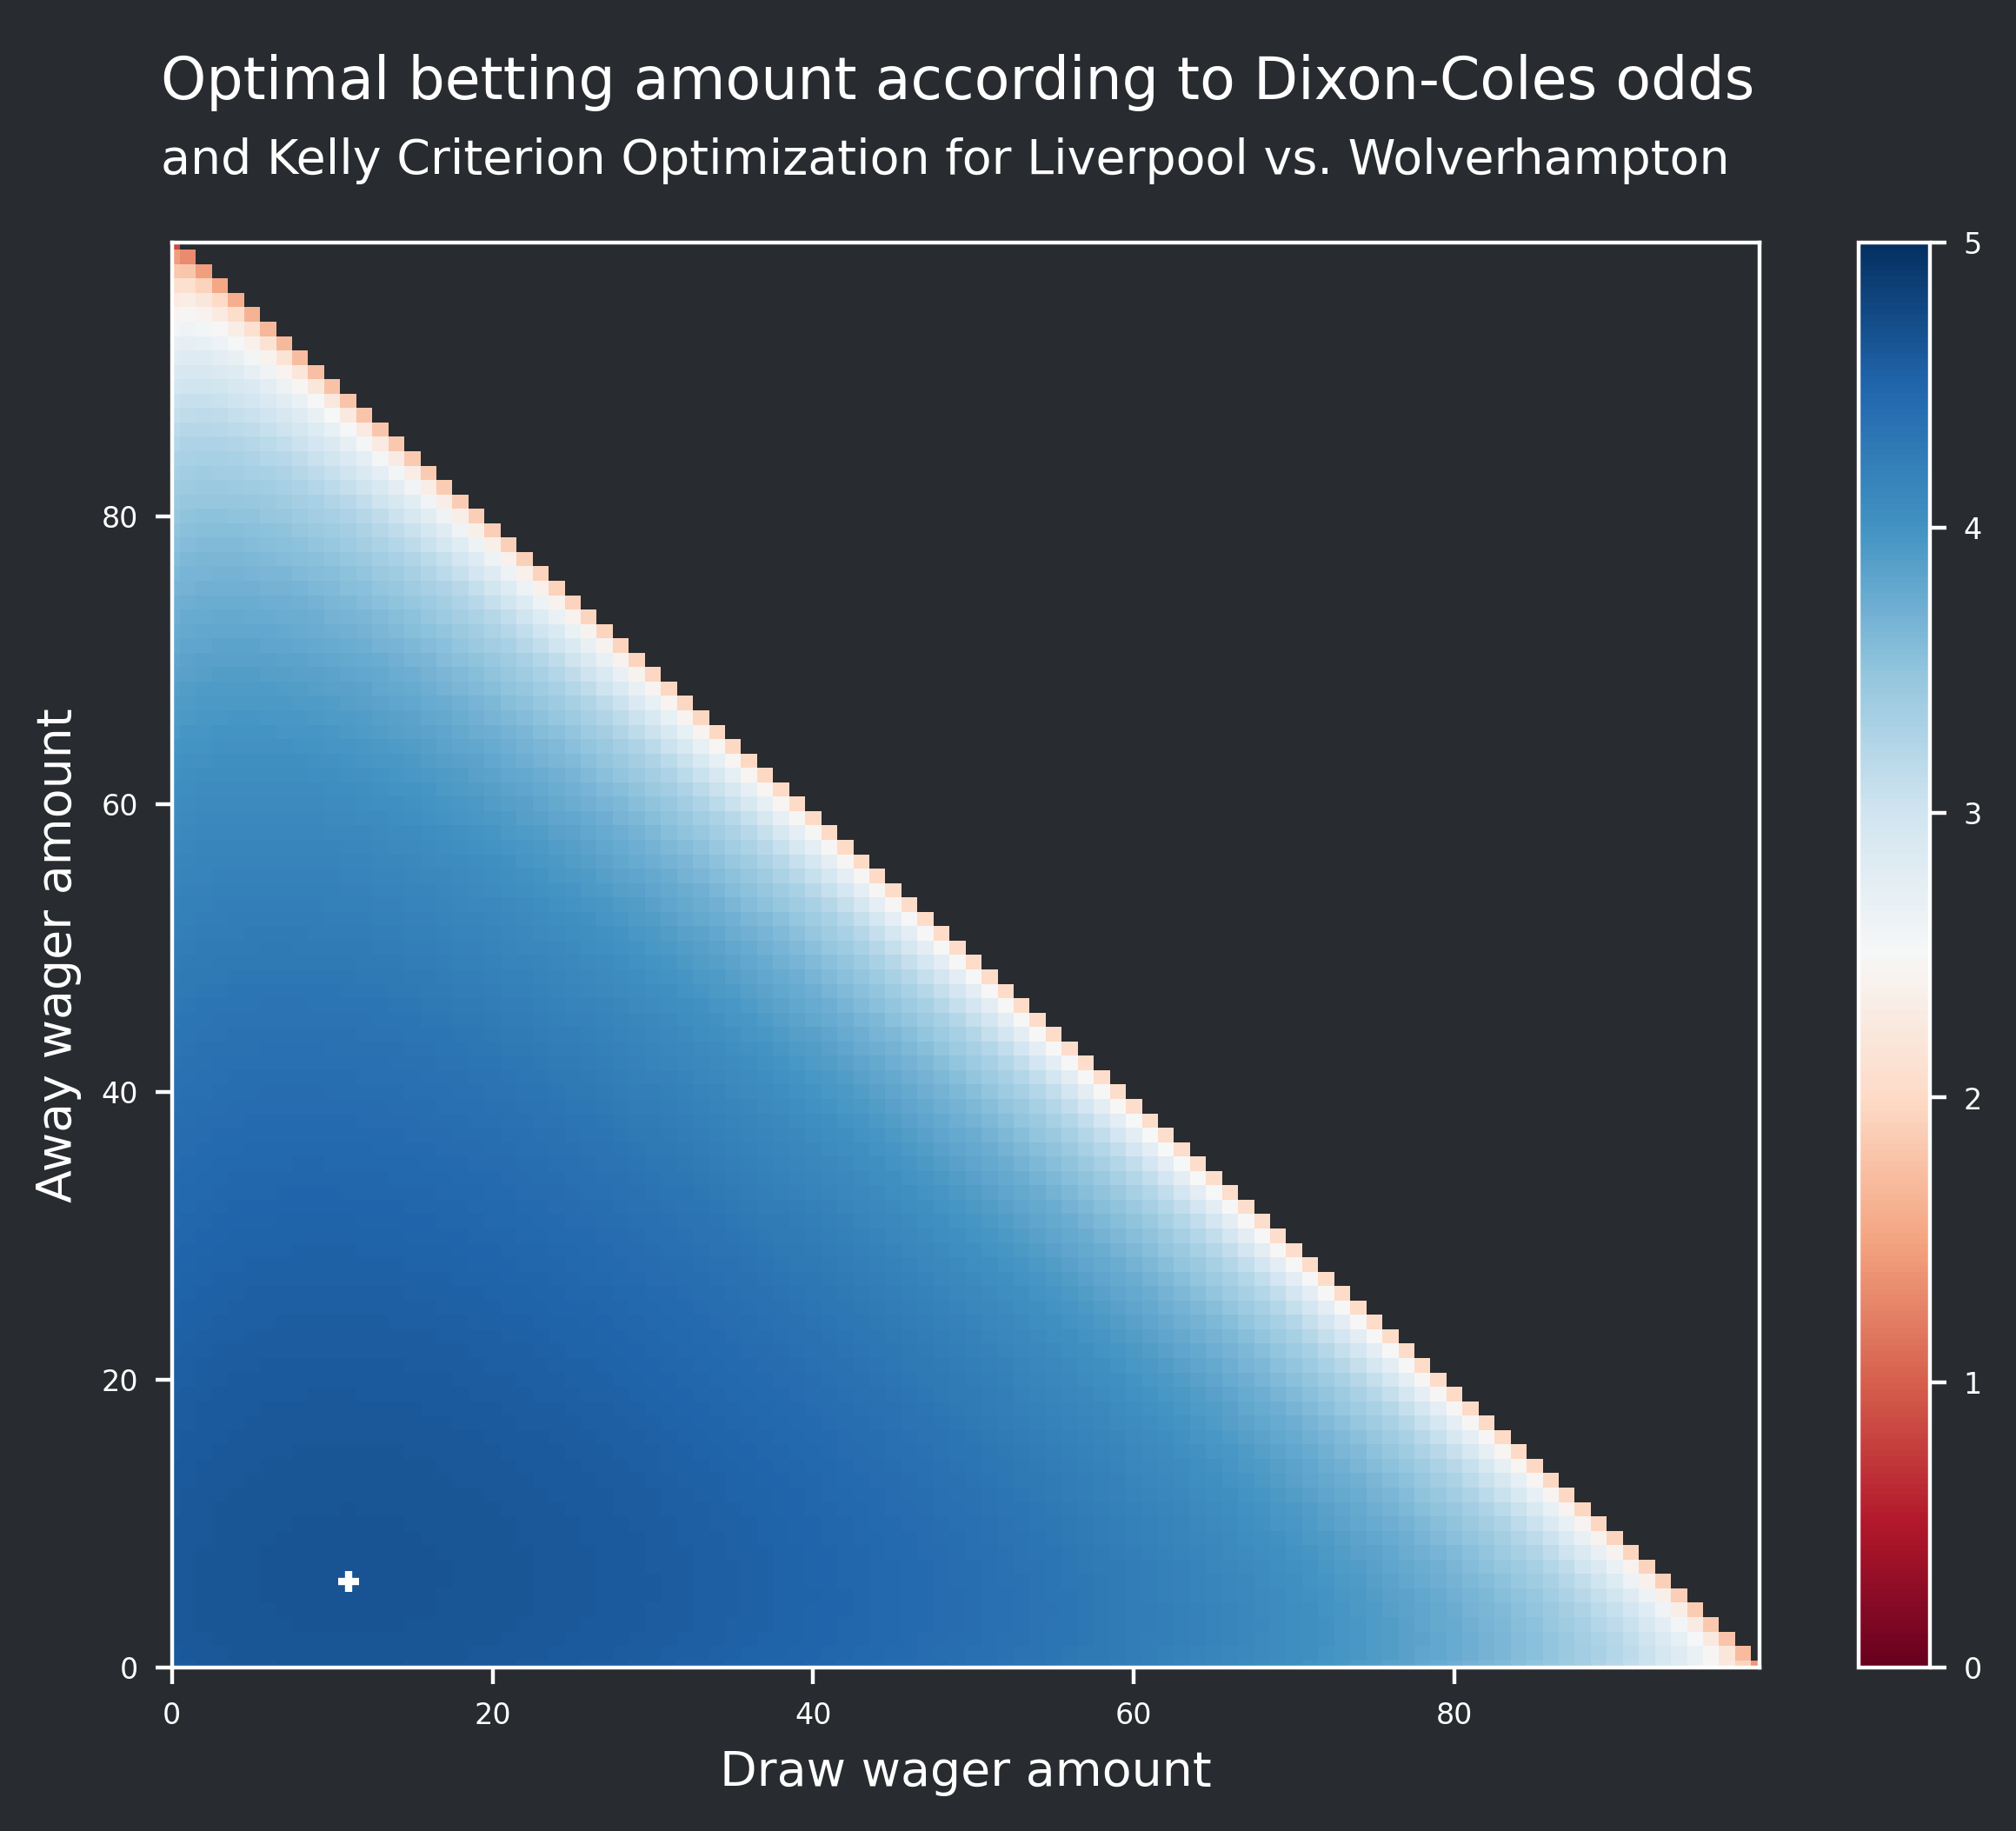

In [23]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

c = ax.pcolormesh(xgrid, ygrid, E, cmap='RdBu', vmin=0, vmax=5)
# set the limits of the plot to the limits of the data
ax.axis([xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()])
fig.colorbar(c, ax=ax)

ax.scatter(
    11,
    6,
    color='w',
    marker='+',
    s=20)

ax.set_xlabel('Draw wager amount')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Away wager amount')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.08, y=1.075,
    s="Optimal betting amount according to Dixon-Coles odds",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.08, y=1.025,
    s="and Kelly Criterion Optimization for Liverpool vs. Wolverhampton",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()